### Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2, glob

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

### Define some preprocessing functions

In [2]:
def extract_n_images(images, labels, n=25):

    '''Extracts n_images images from each class in the dataset.'''
    
    out_images, out_labels = [], []

    # Get the unique classes
    unique_labels = np.unique(labels)

    # Sample n images from each class
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        np.random.shuffle(indices)
        indices = indices[:n]
        out_images.append(images[indices])
        out_labels.append(labels[indices])
    
    # Convert to numpy arrays
    out_images = np.concatenate(out_images, axis=0)  # (n_classes*n_images, h, w, c)
    out_labels = np.concatenate(out_labels, axis=0)  # (n_classes*n_images,)
    
    return out_images, out_labels

In [3]:
def resize_and_grayscale(images, size=(75, 100)):
    
    '''Resizes and converts image to grayscale.'''
    
    out_images = []
    
    # Resize and convert to grayscale
    for image in images:
        image = cv2.resize(image, size)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        out_images.append(image)
    
    return np.array(out_images)

In [4]:
def print_dataset_info(images, labels):

    '''Prints information about the dataset.'''

    print(f'- Number of classes\t: {len(np.unique(labels))} ({np.unique(labels).min()} - {np.unique(labels).max()})')
    print(f'- Number of images\t: {images.shape[0]}')
    print(f'- Image size\t\t: {images.shape[1]} x {images.shape[2]}')
    print(f'- Image channels\t: {images.shape[3] if images.ndim == 4 else 1}')
    print(f'- Image value range\t: {images.min()} - {images.max()}')
    print(f'- Image dtype\t\t: {images.dtype}')

### Our dataset

In [5]:
members = ['honey', 'jane', 'philip', 'veronica', 'wai_yeong']
our_images, our_labels = [], []

# Create our dataset
for i, member in enumerate(members):
    for path in glob.glob(f'output/{member}/*.png'):
        our_images.append(cv2.imread(path))
        our_labels.append(i)

our_images = np.array(our_images)
our_labels = np.array(our_labels)

print('Our dataset before preprocessing')
print_dataset_info(our_images, our_labels)

Our dataset before preprocessing
- Number of classes	: 5 (0 - 4)
- Number of images	: 200
- Image size		: 100 x 75
- Image channels	: 3
- Image value range	: 0 - 255
- Image dtype		: uint8


In [6]:
# Convert BGR to RGB, then normalise to [0, 1]
our_images = (our_images[..., ::-1] / 255.0).astype('float32')

# Resize and convert to grayscale
our_images = resize_and_grayscale(our_images, size=(75, 100))

print('Our dataset after preprocessing')
print_dataset_info(our_images, our_labels)

Our dataset after preprocessing
- Number of classes	: 5 (0 - 4)
- Number of images	: 200
- Image size		: 100 x 75
- Image channels	: 1
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


### LFW dataset 

In [7]:
# Set random seed for reproducibility
np.random.seed(0)

# Load the LFW dataset and extract 25 random images from each class
lfw_people = fetch_lfw_people(min_faces_per_person=40, color=True, resize=1.0)
lfw_images, lfw_labels = extract_n_images(lfw_people.images, lfw_people.target, n=40)

# Offset the labels by 5 to avoid conflict with our dataset
lfw_labels = lfw_labels + len(members)

print('LFW dataset before preprocessing')
print_dataset_info(lfw_images, lfw_labels)

LFW dataset before preprocessing
- Number of classes	: 19 (5 - 23)
- Number of images	: 760
- Image size		: 125 x 94
- Image channels	: 3
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


In [8]:
# Resize and convert to grayscale
lfw_images = resize_and_grayscale(lfw_images, size=(75, 100))

print('LFW dataset after preprocessing')
print_dataset_info(lfw_images, lfw_labels)

LFW dataset after preprocessing
- Number of classes	: 19 (5 - 23)
- Number of images	: 760
- Image size		: 100 x 75
- Image channels	: 1
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


### Combine both datasets

In [9]:
# Combine the LFW and our datasets
# images = np.concatenate([our_images, lfw_images], axis=0)
# labels = np.concatenate([our_labels, lfw_labels], axis=0)

images = np.concatenate([our_images], axis=0)
labels = np.concatenate([our_labels], axis=0)

print('Combined dataset')
print_dataset_info(images, labels)

Combined dataset
- Number of classes	: 5 (0 - 4)
- Number of images	: 200
- Image size		: 100 x 75
- Image channels	: 1
- Image value range	: 0.0 - 1.0
- Image dtype		: float32


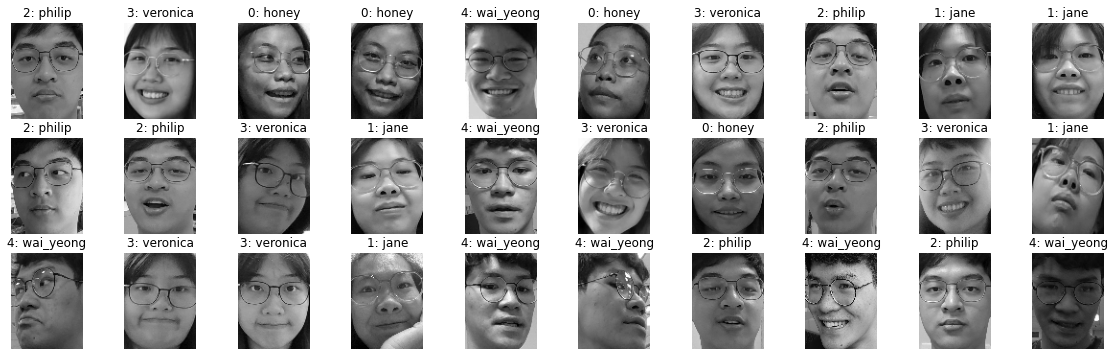

Note: Our members are labelled 0-4 and explicitly shown in the title.


In [10]:
def plot_images(images, labels, n=(5, 5)):

    '''Plots n random images from the dataset.'''
    
    # Randomly sample n images
    indices = np.random.choice(images.shape[0], size=n[0]*n[1], replace=False)
    images = images[indices]
    labels = labels[indices]

    # Plot the images
    plt.figure(figsize=(2*n[0], 2*n[1]), facecolor='white')
    for i in range(n[0]):
        for j in range(n[1]):
            index = i * n[1] + j
            plt.subplot(n[1], n[0], index+1)
            plt.imshow(images[index], cmap='gray')
            if labels[index] < len(members):
                plt.title(f'{labels[index]}: {members[labels[index]]}')
            else:
                plt.title(labels[index])
            plt.axis('off')
    plt.show()

# Set random seed for reproducibility
np.random.seed(7)
plot_images(images, labels, n=(10, 3))

print('Note: Our members are labelled 0-4 and explicitly shown in the title.')

In [11]:
# Convert the images to feature vectors
images = images.reshape(images.shape[0], -1)

# Save the images and labels to disk
np.savez_compressed('artifacts/combined_dataset.npz', images=images, labels=labels)

### Perform train test split

You may use the preprocessed dataset saved earlier.

In [12]:
# Load the dataset from disk
dataset = np.load('artifacts/combined_dataset.npz')
images, labels = dataset['images'], dataset['labels']

# Save some variables for later use
n_classes = len(np.unique(labels))
n_images = images.shape[0]

print('n_classes:', n_classes)
print('n_images:', n_images)

n_classes: 5
n_images: 200


In [13]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, train_size=0.6, stratify=labels, random_state=0)

print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (120, 7500)
X_test: (80, 7500)
y_train: (120,)
y_test: (80,)


In [14]:
# Preview the image counts

df_counts = pd.DataFrame({
    'subject_id': np.arange(n_classes),
    'train': np.unique(y_train, return_counts=True)[1],
    'test': np.unique(y_test, return_counts=True)[1],
    'total': np.unique(labels, return_counts=True)[1]
})

print('Image counts')
df_counts.set_index('subject_id').T

Image counts


subject_id,0,1,2,3,4
train,24,24,24,24,24
test,16,16,16,16,16
total,40,40,40,40,40


### PCA

In [15]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from scipy.spatial.distance import mahalanobis, euclidean
from sklearn.metrics import accuracy_score

import joblib

In [16]:
n_components = 60

# PCA from sklearn
sk_pca = PCA(n_components=n_components, svd_solver='full')
X_train_pca = sk_pca.fit_transform(X_train)
X_test_pca = sk_pca.transform(X_test)

mu_fj = []

for i in range(n_classes):
    subject_indices = np.where(y_train==i)[0]
    mu_fj.append(np.mean(X_train_pca[subject_indices], axis=0))

mu_fj = np.array(mu_fj)

In [17]:
joblib.dump(sk_pca, 'artifacts/sk_pca_nclass_5.joblib')
np.savez_compressed('artifacts/mu_fj_nclass_5.npz', mu_fj=mu_fj)

In [18]:

# train_indices = np.where(y_train < 5)[0]
# test_indices = np.where(y_test < 5)[0]

# X_train_pca = X_train_pca[train_indices]
# X_test_pca = X_test_pca[test_indices]
# y_train = y_train[train_indices]
# y_test = y_test[test_indices]
# mu_fj = mu_fj[:5]

# X_train_pca.shape, X_test_pca.shape, y_train.shape, y_test.shape, mu_fj.shape

In [19]:
inv_pooled_covar = np.diag(1 / sk_pca.explained_variance_[:n_components])

y_train_preds, y_test_preds = [], []

for i in range(len(X_train_pca)):

    dist = np.array([mahalanobis(X_train_pca[i], mu_fj[j], inv_pooled_covar) for j in range(n_classes)])
    # dist = np.array([euclidean(X_train_pca[i], mu_fj[j]) for j in range(n_classes)])
    y_train_preds.append(np.argmin(dist))

for i in range(len(X_test_pca)):

    dist = np.array([mahalanobis(X_test_pca[i], mu_fj[j], inv_pooled_covar) for j in range(n_classes)])
    # dist = np.array([euclidean(X_test_pca[i], mu_fj[j]) for j in range(n_classes)])
    y_test_preds.append(np.argmin(dist))

accuracy_score(y_train_preds, y_train), accuracy_score(y_test_preds, y_test)

(1.0, 0.875)

In [20]:
sk_lda = LinearDiscriminantAnalysis(solver='svd')
X_train_lda = sk_lda.fit_transform(X_train_pca, y_train)
X_test_lda = sk_lda.transform(X_test_pca)

# mu_fj = []

# for i in range(n_classes):
#     subject_indices = np.where(y_train==i)[0]
#     mu_fj.append(np.mean(X_train_lda[subject_indices], axis=0))

accuracy_score(sk_lda.predict(X_train_pca), y_train), accuracy_score(sk_lda.predict(X_test_pca), y_test)

(1.0, 0.8875)

In [21]:
indices = np.where(y_test < 5)[0]
accuracy_score(sk_lda.predict(X_test_pca)[indices], y_test[indices])

0.8875

In [24]:
pca = joblib.load('artifacts/sk_pca_nclass_5.joblib')
pca.transform(X_test)

array([[ 2.0226331e+00,  7.4660234e+00, -9.2963213e-01, ...,
        -1.0784408e-01,  3.9946839e-01,  4.7467160e-01],
       [ 1.4269340e+00,  7.3497810e+00,  3.4824264e-01, ...,
        -7.3171191e-02, -2.5359612e-02, -6.6915971e-01],
       [-1.8117832e+00,  5.6815767e+00, -1.7214168e+00, ...,
        -2.3121309e-01, -1.6202153e-01, -8.9246124e-02],
       ...,
       [-2.0397229e+00, -3.2912595e+00,  1.8232850e+00, ...,
        -2.5082511e-01, -1.5487981e-01, -2.6382196e-01],
       [-1.0292383e+01, -2.7132096e+00, -1.9251759e+00, ...,
         5.9864950e-01, -7.7717133e-02, -4.7406006e-01],
       [ 3.3521086e-02, -3.7238977e+00,  2.6065285e+00, ...,
         2.3596968e-01, -1.2812075e-01,  9.8605789e-03]], dtype=float32)